<a href="https://colab.research.google.com/github/simonwoodhead/course-v3/blob/master/lesson1_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   2260      0 --:--:-- --:--:-- --:--:--  2260
Updating fastai...
Done.


# Lesson 1 - Homework Lego Technic or Classic?

In Lesson 1 we learnt how to run our first image classifier, in this homework we will apply the same technique to our own dataset. 

I photographed 75 Lego bricks: 35 Classic and 40 Technic. I took the photographs very quickly and against the same background (my dining room table). I was not aiming to create a brilliant dataset here but to create something myself to learn the complete process.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use my tiny dataset of 75 Lego bricks which features 2 types: Classic and Technic. Our model will need to learn to differentiate between these 2 types.

In Lesson 1 we used `untar_data` to download and extract the data from a `.tgz` file. For this homework exercise I am using Google Colab and I will [import the data from Google Drive](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd).

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Show the directory contents or use the "Files" tab in the left sidebar
!ls "/content/gdrive/My Drive/lego"

models	train  valid


In Lesson 1 `untar_data` downloaded and extracted our data to a folder and returned a `PosixPath`. We do not need to download and extract our Lego images, they are just in the Google Drive folder, but we do need a `PosixPath` for which we can use the [pathlib](https://docs.python.org/3/library/pathlib.html) library.

In [0]:
from pathlib import Path
path = Path('/content/gdrive/My Drive/lego')

In [8]:
path

PosixPath('/content/gdrive/My Drive/lego')

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the folder structure. So all images in `/classic/` should have the `classic` label. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_folder` gets the labels from the folder names.

At first I got the folder structure wrong. The required folder structure for `from_folder` is:

```
train/
  label1/
    001.jpg
    002.jpg
    ...
  label2/
    001.jpg
    002.jpg
    ...
valid/
  label1/
    001.jpg
    002.jpg
    ...
  label2/
    001.jpg
    002.jpg
    ...
```

where the `train` and `valid` folder names are important. The label folder names are used as the labels and the filenames can be anything.

When calling `from_folder` you can pass in a `size` parameter which is passed to the `ds_tfms` transform functions. In the examples in class a single value was used so the images were made square. You can also pass in a tuple e.g. `size=(200,300)` will rescale so the images are 200 pixels high and 300 pixels wide. 

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=(200,300))

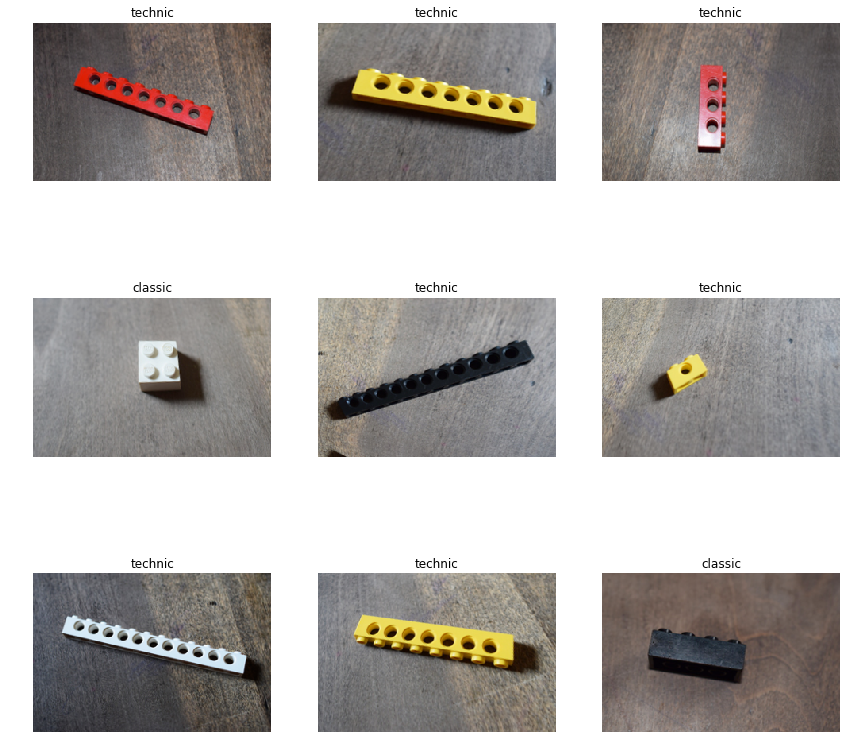

In [10]:
data.show_batch(rows=3, figsize=(12,12))

In [11]:
fnames = get_image_files(path/'train'/'classic')
fnames[:5]

[PosixPath('/content/gdrive/My Drive/lego/train/classic/DSC_0969.JPG'),
 PosixPath('/content/gdrive/My Drive/lego/train/classic/DSC_0972.JPG'),
 PosixPath('/content/gdrive/My Drive/lego/train/classic/DSC_0970.JPG'),
 PosixPath('/content/gdrive/My Drive/lego/train/classic/DSC_0971.JPG'),
 PosixPath('/content/gdrive/My Drive/lego/train/classic/DSC_0973.JPG')]

In [12]:
print(data.classes)
len(data.classes),data.c

['classic', 'technic']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [13]:
doc(cnn_learner)

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 112042899.37it/s]


In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In the lesson we ran for 4 epochs. I found that the error_rate was still very high at that point for my lego data so I ran for 20 epochs. It may have been high because we do not have many images or because our images are very large. I was surprised that the `train_loss` and `valid_loss` were so different because I used the same data for the training and validation sets (which I should not have done but I had not split them yet). It may be to do with the `ds_tfms` which gets transforms to apply to your data. To create a larger dataset to train on it rotates, skews, flips, translates etc, so the training and validation datasets would not match.

In [16]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.294679,0.764366,0.453333,00:12
1,1.102865,0.711053,0.400000,00:01
2,0.987500,0.672682,0.360000,00:01
3,0.857793,0.656564,0.320000,00:01
4,0.747982,0.710717,0.306667,00:01
5,0.648280,0.813825,0.306667,00:01
6,0.581459,0.813972,0.280000,00:01
7,0.516687,0.779384,0.253333,00:01
8,0.462160,0.770795,0.253333,00:01
9,0.416750,0.761417,0.240000,00:01


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

The top losses is very interesting because I ran my model for so many epochs it fitted the data very closely (possibly too closely). Only the first two classes were incorrectly classified (predicted as `classic` when they are actually `technic`), all others were predicted correctly but were still in the "top losses". (Then I ran again and there were 9 errors, damn randomness!)

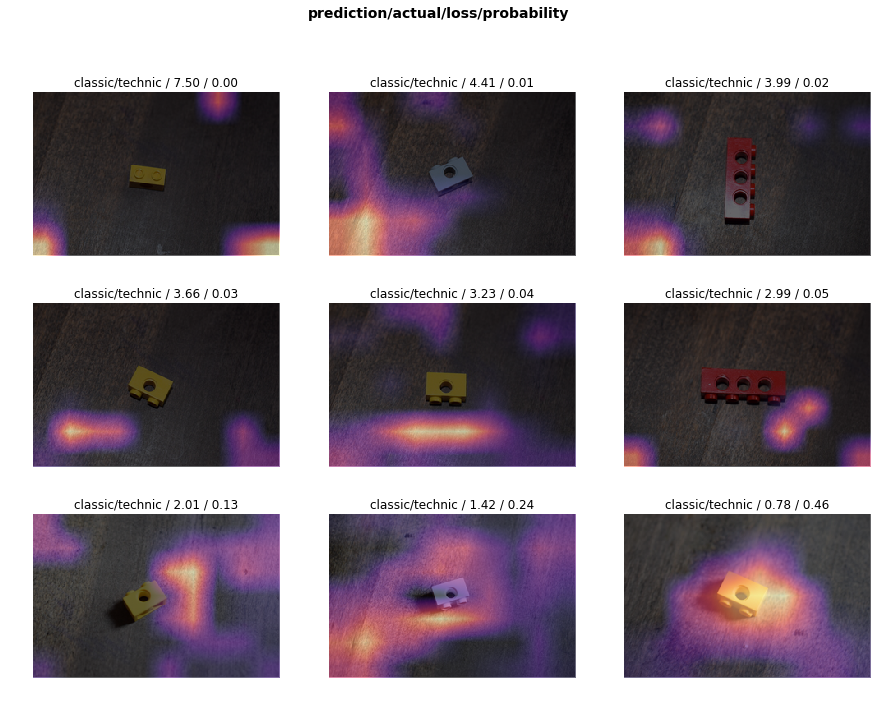

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
doc(interp.plot_top_losses)

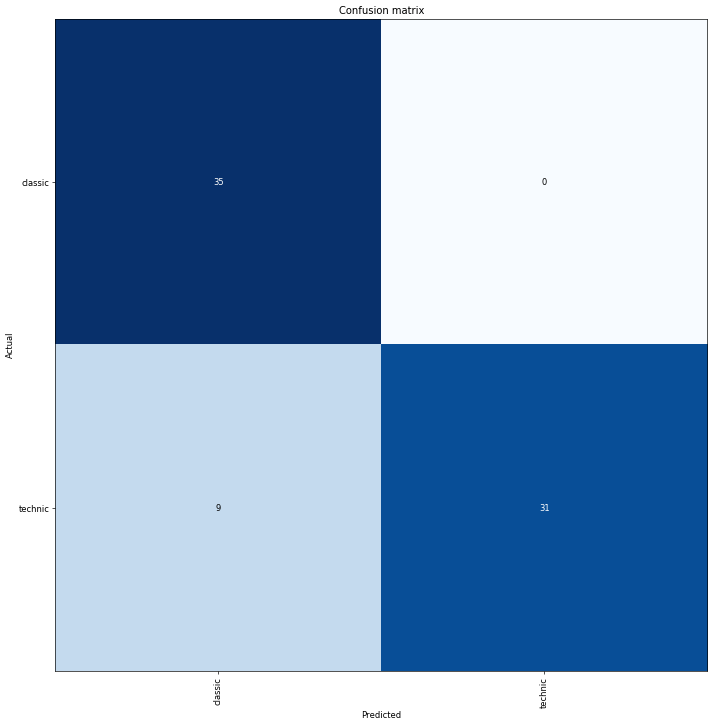

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=2)

[('technic', 'classic', 9)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.027915,0.523446,0.133333,00:02


Notice that the error rate can actually get worse! This can happen because the weights is the resnet34 model were trained on the whole ImageNet dataset. The eraly layers detect things like edges so it is unlikely that our additional dataset is going to be able to improve the training of those weights. Later layers pick up more details (e.g. lizard's eyes). These later layers are more important for us to train. Reset the weights by reloading the ones we saved earlier. 

In [0]:
learn.load('stage-1');

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


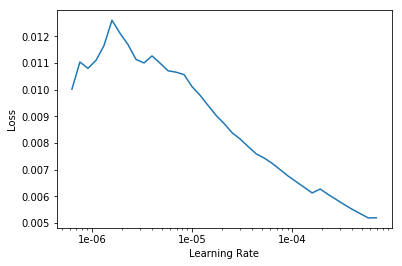

In [28]:
learn.recorder.plot()

In the lesson we found that increasing the learning rate lead to higher losses. In this case it seems that this is not the case for our data. The larger the step we take the smaller the loss. This just doesn't seem logical, you would expect that if the steps get too big the loss might increase as we stop converging.


In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.008366,0.398040,0.106667,00:02
1,0.009512,0.279644,0.093333,00:02


That's a pretty accurate model!